In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Repair archive
# sudo zip -FF T162.zip --out T162Repaired.zip

In [42]:
from typing import List
from datasetsforecast.long_horizon import LongHorizon
import pandas as pd
import numpy as np
import torch
from typing import Optional

import os, pathlib
from glob import glob

from torch.utils.data import Dataset, DataLoader, Subset
from tqdm.auto import tqdm

from dataset import LongHorizonUnivariateDataModule, LongHorizonUnivariateDataset
from dataset import ElectricityUnivariateDataModule, ElectricityUnivariateDataset

import pytorch_lightning as pl
from omegaconf import OmegaConf
from utils.model_factory import instantiate

from onedrivedownloader import download

from statsforecast.models import AutoETS, ETS, Theta, AutoCES

from metrics import SMAPE, MAPE, CRPS

RESULTS_DIR = './results'
# MANDATORY_TESTING_QUANTS = [0.5, 0.001, 0.01, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99, 0.999]
MANDATORY_TESTING_QUANTS = np.concatenate([[0.5], [0.001], np.arange(0.01,0.5,0.01), np.arange(0.51,1,0.01), [0.999]]) 

In [43]:
def marfe(df, actuals_col="actuals", predictions_col="predictions", quantiles_col="quants", bin_size=0.001):
    df_cpy = df[[actuals_col, predictions_col, quantiles_col]].reset_index(drop=True).copy()
    
    df_cpy["quants_bins"] = np.round(df_cpy[quantiles_col], int(np.log10(1/bin_size))).values
    df_cpy["ReFr"] = df_cpy[actuals_col] < df_cpy[predictions_col]
    refr = df_cpy.groupby('quants_bins')["ReFr"].mean()
    # refr.drop([0.0, 1.0], inplace=True)
    return np.mean(np.abs(refr.values - refr.index))

In [105]:
# epoch = 4
# root_path = os.path.join(RESULTS_DIR, 'MHLV/slawek')

epoch = 1
root_path = os.path.join(RESULTS_DIR, 'MHLV/NBEATSAQFILM-maxnorm=False-loss=MQNLoss')

crps_rnd = CRPS()
crps_fixed = CRPS()
mape = MAPE()

tot_len = 0
num_nulls = {}

dfs_all = []
marfe_ts = []
dfs_all_fixed = []
df_quants_ts = []
for ts in tqdm(range(35)):
    paths = glob(os.path.join(root_path, f'e{epoch}w*_{ts}.pickle'))
    df = pd.concat([pd.read_pickle(p) for p in paths], axis=1)
    # Remove rows corresponding to the nan values in actuals, implying invalid ground truth observations
    num_nulls[ts] = num_nulls.get(ts, 0) + df.actuals.isnull().sum()
    df = df[~df.actuals.isnull()]
    
    df['predictions'] = df[df.columns[df.columns.str.startswith('forec')]].mean(axis=1).values
    
    mandatory_quants = df.quants.isin(np.array(MANDATORY_TESTING_QUANTS))
    df_rnd = df[~mandatory_quants]
    df_fixed = df[mandatory_quants]
    
    crps_rnd.update(preds=torch.Tensor(df_rnd['predictions'].values)[None], 
                    target=torch.Tensor(df_rnd['actuals'].values)[None], 
                    q=torch.Tensor(df_rnd['quants'].values)[None])
    
    crps_fixed.update(preds=torch.Tensor(df_fixed['predictions'].values)[None], 
                      target=torch.Tensor(df_fixed['actuals'].values)[None], 
                      q=torch.Tensor(df_fixed['quants'].values)[None])
    
    
    median_quants = df_fixed.quants.isin(np.array([0.5]))
    mape.update(target=torch.Tensor(df_fixed['actuals'][median_quants].values),
                preds=torch.Tensor(df_fixed['predictions'][median_quants].values))
    
    tot_len += len(df)
    dfs_all.append(df_rnd)
    dfs_all_fixed.append(df_fixed)

    marfe_ts.append(marfe(df_fixed, bin_size=0.01))

    df_quants = df_fixed[['actuals','predictions','quants']].copy()
    df_quants[ts] = df_quants['actuals'] < df_quants['predictions']
    df_quants_ts.append(df_quants.groupby('quants')[ts].mean())

df_quants_ts = pd.concat(df_quants_ts, axis=1).T
dfs_all = pd.concat(dfs_all)
dfs_all_fixed = pd.concat(dfs_all_fixed)
print("CRPS random quants", crps_rnd.compute().cpu().numpy())
print("CRPS mandatory quants", crps_fixed.compute().cpu().numpy())
print("MAPE", mape.compute().cpu().numpy())
print("MARFE", marfe(dfs_all, bin_size=0.01))


  0%|          | 0/35 [00:00<?, ?it/s]

CRPS random quants 212.24443
CRPS mandatory quants 210.09549
MAPE 2.4731493
MARFE 0.020835660936922705


In [106]:
df_quants_ts.to_excel('results/df_quants_ts.xlsx')
df_quants_ts.mean()

quants
0.001    0.004706
0.010    0.011694
0.020    0.021815
0.030    0.032988
0.040    0.043967
           ...   
0.960    0.938049
0.970    0.946248
0.980    0.953363
0.990    0.959884
0.999    0.965050
Length: 101, dtype: float64

In [107]:
marfe(dfs_all, bin_size=0.01)

0.020835660936922705

In [108]:
marfe(dfs_all_fixed, bin_size=0.01)

0.020814154787798727

In [109]:
np.mean(marfe_ts)

0.028116365512817803

In [110]:
np.abs(df_quants_ts - np.array(df_quants_ts.columns)[None]).values.mean()

0.02809690263246392

In [104]:
df_Grzegorz = pd.read_excel('results/Grzegorz/RF.xlsx', header=None)
df_Grzegorz.columns = df_quants_ts.columns[1:-1]

np.abs(df_Grzegorz - np.array(df_Grzegorz.columns)[None]).values.mean()

0.03307098060669496

quants,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10,...,0.90,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99
0,0.008528,0.019116,0.029934,0.039950,0.050195,0.061184,0.071543,0.080529,0.090373,0.099073,...,0.872196,0.882097,0.893201,0.904533,0.914778,0.924222,0.932177,0.941163,0.948603,0.956158
1,0.007841,0.015053,0.025011,0.035371,0.046074,0.055632,0.064618,0.074691,0.083791,0.094208,...,0.866930,0.879293,0.892571,0.906078,0.917525,0.929087,0.939160,0.947287,0.953583,0.960394
2,0.006124,0.010646,0.016884,0.024210,0.031021,0.038290,0.045501,0.053915,0.061985,0.070055,...,0.886848,0.899783,0.913919,0.924851,0.936012,0.945685,0.954670,0.961825,0.968979,0.974760
3,0.023924,0.044013,0.064503,0.082990,0.097756,0.113324,0.125801,0.138507,0.149096,0.159741,...,0.816392,0.828354,0.839400,0.851591,0.863610,0.874256,0.884787,0.894345,0.904647,0.913061
4,0.008585,0.015453,0.022951,0.029590,0.038977,0.046761,0.055460,0.063874,0.071257,0.079327,...,0.889137,0.899496,0.910428,0.919872,0.928114,0.937672,0.945570,0.951866,0.957074,0.961996
5,0.009673,0.021291,0.036115,0.050652,0.065705,0.079899,0.092033,0.103480,0.115041,0.125515,...,0.831387,0.841918,0.854109,0.864755,0.875172,0.884787,0.894975,0.903961,0.912374,0.919128
6,0.006525,0.012534,0.020261,0.028331,0.038347,0.048306,0.057120,0.067250,0.077324,0.087168,...,0.892113,0.905220,0.919128,0.930174,0.940762,0.950149,0.958848,0.966117,0.972413,0.977850
7,0.013107,0.020948,0.030220,0.041152,0.051454,0.060955,0.070971,0.078182,0.087168,0.097127,...,0.885245,0.898523,0.910485,0.922619,0.933150,0.941793,0.948947,0.957074,0.964171,0.970467
8,0.014366,0.028846,0.042296,0.052541,0.063301,0.073947,0.086023,0.095868,0.105884,0.116129,...,0.846383,0.858230,0.868933,0.880552,0.890339,0.899496,0.908425,0.917754,0.925595,0.932406
9,0.016541,0.029418,0.041380,0.052656,0.065190,0.077381,0.087111,0.096841,0.107658,0.116358,...,0.797505,0.808551,0.820456,0.833047,0.843292,0.852392,0.860462,0.866987,0.872711,0.877690


## Analyze Pawel's results

In [163]:
root_path = os.path.join(RESULTS_DIR, 'pawel')
algo = 'dotm'
bin_size = 0.001

dfs_all = []
marfe_ts = []
for ts in tqdm(range(35)):
    df = pd.read_pickle(os.path.join(root_path, f'{algo}_{ts}.pickle'))
    df = df[~df.actuals.isnull()]

    mandatory_quants = df.quants.isin(np.array(MANDATORY_TESTING_QUANTS))
    df_rnd = df[~mandatory_quants]

    dfs_all.append(df_rnd)
    
    marfe_ts.append(marfe(df_rnd, predictions_col="aggForec", bin_size=bin_size))

dfs_all = pd.concat(dfs_all)

print(f"MARFE {algo}", marfe(dfs_all, predictions_col="aggForec", bin_size=bin_size))

  0%|          | 0/35 [00:00<?, ?it/s]

MARFE dotm 0.0207857571455102


In [ ]:

MARFE dotm 0.0207857571455102
MARFE snaive 0.03546889814622456
MARFE arima 0.025583501139113167
MARFE mlp 0.01721498534369242

In [150]:
ls results/pawel

arima_0.pickle    dotm_26.pickle   snaive_10.pickle  tft_27.pickle
arima_10.pickle   dotm_27.pickle   snaive_11.pickle  tft_28.pickle
arima_11.pickle   dotm_28.pickle   snaive_12.pickle  tft_29.pickle
arima_12.pickle   dotm_29.pickle   snaive_13.pickle  tft_2.pickle
arima_13.pickle   dotm_2.pickle    snaive_14.pickle  tft_30.pickle
arima_14.pickle   dotm_30.pickle   snaive_15.pickle  tft_31.pickle
arima_15.pickle   dotm_31.pickle   snaive_16.pickle  tft_32.pickle
arima_16.pickle   dotm_32.pickle   snaive_17.pickle  tft_33.pickle
arima_17.pickle   dotm_33.pickle   snaive_18.pickle  tft_34.pickle
arima_18.pickle   dotm_34.pickle   snaive_19.pickle  tft_3.pickle
arima_19.pickle   dotm_3.pickle    snaive_1.pickle   tft_4.pickle
arima_1.pickle    dotm_4.pickle    snaive_20.pickle  tft_5.pickle
arima_20.pickle   dotm_5.pickle    snaive_21.pickle  tft_6.pickle
arima_21.pickle   dotm_6.pickle    snaive_22.pickle  tft_7.pickle
arima_22.pickle   dotm_7.pickle    snaive_23.pickle  tft_8.pickle
ar

In [148]:
np.mean(marfe_ts)

0.027535440928981976

<Axes: >

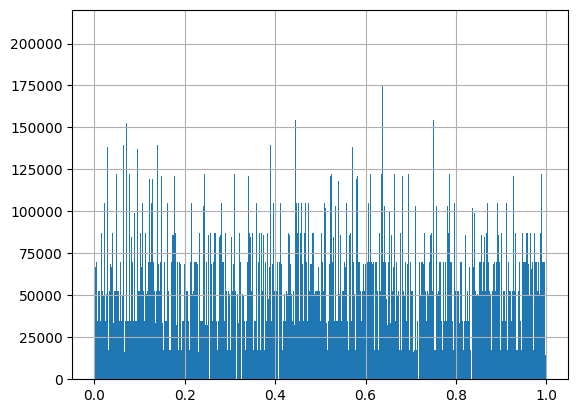

In [164]:
dfs_all.quants.hist(bins=1000)

<Axes: >

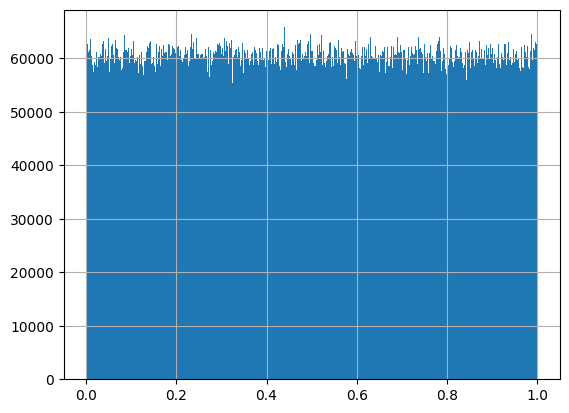

In [166]:
dfs_all.quants.hist(bins=1000)